In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf import ao2mo, gto, mcscf, scf
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_nature.second_q.circuit.library.initial_states.hartree_fock import HartreeFock
from qiskit_algorithms.time_evolvers.time_evolution_problem import TimeEvolutionProblem 
from scipy_imaginary_solver_modif import SciPyImaginaryEvolver
from pyscf_molecule import Molecule
from utils import make_geometry
from qiskit_nature.second_q.mappers import JordanWignerMapper
from ham import build_hamiltonian, get_fermionic_ops
from qiskit.circuit import ParameterVector

In [2]:
## Mol object

molecule = 'H2'
basis_set =  'ccpvdz'
charge = 0
spin = 0

In [3]:
ham, active_space = build_hamiltonian(molecule, basis_set, 0, 0, 'jordan_wigner')
print(ham)

Running restricted UHF (!)... (might want RHF)
converged SCF energy = -1.12871101060159
converged SCF energy = -1.12871101060159
-1.1287110106015903
UHF done.
converged SCF energy = -1.12871101060159
converged SCF energy = -1.12871101060159
CASCI E = -1.13145068427839  E(CI) = -1.84559000000438  S^2 = 0.0000000
accuracy of Cholesky decomposition  2.7755575615628914e-16
SparsePauliOp(['IIII', 'IIIZ', 'IZII', 'IIZI', 'ZIII', 'IZIZ', 'IIZZ', 'ZIIZ', 'IZZI', 'ZZII', 'ZIZI', 'YYYY', 'XXYY', 'YYXX', 'XXXX'],
              coeffs=[-0.44756101+0.j, -0.28244902+0.j, -0.28244902+0.j,  0.00402246+0.j,
  0.00402246+0.j,  0.16465817+0.j,  0.08211967+0.j,  0.09614389+0.j,
  0.09614389+0.j,  0.08211967+0.j,  0.08366192+0.j,  0.01402422+0.j,
  0.01402422+0.j,  0.01402422+0.j,  0.01402422+0.j])


In [ ]:
tau = 5.0
dtau_init = 0.001
nsteps = int(tau // dtau_init)
probe = 50
mapper = JordanWignerMapper()
filename = "qite_h2_var"



num_spatial_orbitals = len(list(active_space))
num_elec = num_spatial_orbitals


def _HartreeFock(num_spatial_orbitals, n_elec, mapper=JordanWignerMapper()):
    return HartreeFock(num_spatial_orbitals, (n_elec//2, n_elec//2), mapper)

def qite(ham, tau, initial_state, nsteps, params, filename=None):
    evol_pb = TimeEvolutionProblem(ham, tau, initial_state, aux_operators=[ham])
    imag_evolver = SciPyImaginaryEvolver(num_timesteps=nsteps)
    result = imag_evolver.evolve(evol_pb, params, filename=filename)
    return result

def create_params(num_steps):
    params = ParameterVector('dtau', length=num_steps)
    return params





In [ ]:

# initial_params = create_params(nsteps)
# bound_params = {param: dtau_init for param in initial_params}  # Create a dictionary of bindings
# initial_params = initial_params.params.bind(bound_params)  # Bind the values to the ParameterVector
# for param in initial_params.param:
# print(initial_params[1])
# # initial_params = initial_params.bind(dtau_init)
# for param in initial_params:
#     param.bind(dtau_init)

rng = np.random.default_rng()
initial_params_normal = rng.normal(dtau_init,10*dtau_init,(nsteps,))
initial_params_uniform = np.ones((nsteps,)) * dtau_init

ts_normal = []
t = 0
for param in initial_params_normal:
    t += param
    ts_normal.append(t)
t=0
ts_uniform =[]
for param in initial_params_uniform:
    t += param
    ts_uniform.append(t)

ts_normal = np.array([ts_normal])
ts_uniform = np.array([ts_uniform])

initial_state = _HartreeFock(num_spatial_orbitals, num_elec, mapper=mapper)

# result_circ = QuantumCircuit(2*mol.nelectron)
# result_circ.initialize(result.evolved_state)
# result_circ.draw('mpl')

In [6]:
result_uniform = qite(ham, tau, initial_state, nsteps, initial_params_uniform, filename+'_uniform')
result_normal = qite(ham, tau, initial_state, nsteps, initial_params_normal, filename+'_normal')


NameError: name 'self' is not defined

In [ ]:
energies_uniform = result_uniform.observables[0][0][::probe]
energies_normal = result_normal.observables[0][0][::probe]
print(len(result_uniform.observables[0]))
print(result_uniform.observables[0])



2
(array([ 0.01717489+0.j,  0.01716859+0.j,  0.01716228+0.j, ...,
       -1.12661399+0.j, -1.12662506+0.j, -1.12663612+0.j], shape=(5000,)), array([0., 0., 0., ..., 0., 0., 0.], shape=(5000,)))


/Users/timoj/Documents/EPFL_local/MA3/Project/venv_pennylane/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/timoj/Documents/EPFL_local/MA3/Project/venv_pennylane/lib/python3.11/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


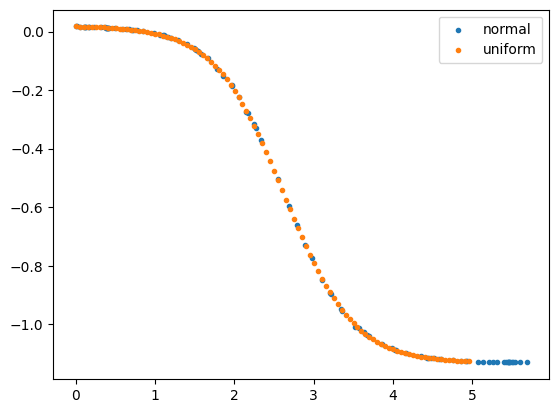

In [ ]:
plt.figure()
plt.scatter(ts_normal[0,::probe], energies_normal, label='normal', marker='.')
plt.scatter(ts_uniform[0,::probe], energies_uniform, label='uniform', marker='.')
plt.legend()

# TODO

Implement cost function

# Optional

Implement Bravyi-Kitaev mapping for fermionic --> qubit Hamiltonian
